In [1]:
from utils import * 
from config import parameters

import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from math import sqrt
from statsmodels.tsa.stattools import grangercausalitytests

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

fred_gdp_quarterly_csv_filepath = parameters.fred_gdp_quarterly_csv_filepath 
fred_unemp_quarterly_csv_filepath = parameters.fred_unemp_quarterly_csv_filepath 
fred_unemp_not_adjusted_quarterly_csv_filepath = os.path.join(parameters.data_dir, 'fred_unemp_not_adjusted_quarterly.csv') 
fred_interest_rate_quarterly_csv_filepath = os.path.join(parameters.data_dir, 'fred_interest_rate_quarterly.csv') 
fred_ted_spread_quarterly_csv_filepath = os.path.join(parameters.data_dir, 'fred_ted_spread_quarterly.csv') 
yahoo_djia_quarterly_csv_filepath = os.path.join(parameters.data_dir, 'yahoo_djia_quarterly.csv')
inf1 = os.path.join(parameters.data_dir, 'fred_inflation_rate_percentage_change_quarterly.csv')
inf2 = os.path.join(parameters.data_dir, 'fred_inflation_rate_quarterly.csv')
fred_index_filepath_dict = {'gdp': fred_gdp_quarterly_csv_filepath, 'unemployment': fred_unemp_quarterly_csv_filepath, 'unemployment_not_adjusted': fred_unemp_not_adjusted_quarterly_csv_filepath, 'interest_rate': fred_interest_rate_quarterly_csv_filepath, 'ted_spread': fred_ted_spread_quarterly_csv_filepath, 'djia': yahoo_djia_quarterly_csv_filepath, 'inflation_rate_percentage_change': inf1, 'inflation_rate': inf2}
fred_index_dict_pkl_filepath = os.path.join(parameters.output_base_dir, 'fred_index_dict.pkl')
fred_index_dict = get_index_dict(fred_index_dict_pkl_filepath, fred_index_filepath_dict)

bigram_uniqueness_strength_pkl_filepath = os.path.join(parameters.output_base_dir, 'bigram-emerging_topic_score-strength_20191123-19-10-46.pkl')
bigram_uniqueness_strength_dict = load_pkl(bigram_uniqueness_strength_pkl_filepath)

base_dir: /home/dmlab/jihye/GIT/bis_speeches_text_bigram_frequency
Parameters(
  sentence_length_outlier = [0, 1, 2, 181, 252]
  bigram_window_size = 15
  bigram_max_rank = None
  stopword_list = ['financial', 'market', 'federal', 'bank', 'banking', 'bankers', 'speech', 'bi', 'review', 'year', 'reserve', 'policy', 'state', 'central', 'board', 'percent', 'rate', 'mr', 'alan', 'greenspan', 'ben', 'bernanke', 'janet', 'yellen', 'jerome', 'powell', 'vol', 'ha', 'wa', 'ii']
  ws_quarterly = 4
  ws_semiannually = 2
  ws_annually = 1
  strength_alpha = 0.9
  base_dir = /home/dmlab/jihye/GIT/bis_speeches_text_bigram_frequency
  data_dir = /home/dmlab/jihye/GIT/bis_speeches_text_bigram_frequency/data
  output_base_dir = /home/dmlab/jihye/GIT/bis_speeches_text_bigram_frequency/output
  bis_raw_pkl_filepath = /home/dmlab/jihye/GIT/bis_speeches_text_bigram_frequency/data/bis_w_content_FINAL.pkl
  fred_gdp_quarterly_csv_filepath = /home/dmlab/jihye/GIT/bis_speeches_text_bigram_frequency/data/fred_g

### frequency, emerging_topic_score, strength

In [2]:
# parameter
target_keyword = 'inflation'
rolling_window = 3

### NOT ALIGNED

In [3]:
indices = ['inflation_rate', 'inflation_rate_percentage_change']
period_dict = dict()
proposed_data_x_dict = {'frequency': dict(), 'emerging_topic_score': dict(), 'strength': dict()}
fred_data_y_dict = dict()
for index_ in indices:
    period_dict[index_] = list()
    proposed_data_x_dict['frequency'][index_] = list()
    proposed_data_x_dict['emerging_topic_score'][index_] = list()
    proposed_data_x_dict['strength'][index_] = list()
    fred_data_y_dict[index_] = list()

# align
for index_name in fred_data_y_dict.keys():
    _period_dict = bigram_uniqueness_strength_dict['quarterly']

    for _period in sorted(_period_dict.keys()): 
        # in case of fred_index_dict has no recent or past information.
        if _period not in fred_index_dict[index_name] or _period == '1999_Q1':
            continue
        count = 0
        _sum_freq, _sum_emerging_topic_score, _sum_strength = 0, 0, 0
        for _bigram, (_freq, _emerging_topic_score, _strength) in sorted(_period_dict[_period].items(),
                                                               key=lambda t: t[-1][0],
                                                               reverse=True):  # CONTROL PRINTING ORDER
            if target_keyword not in _bigram:
                continue
                
            count += 1
            _sum_freq += _freq
            _sum_emerging_topic_score += _emerging_topic_score
            _sum_strength += _strength
            
###################
        # data append
        period_dict[index_name].append(_period)
        proposed_data_x_dict['frequency'][index_name].append(-_sum_freq)
        proposed_data_x_dict['emerging_topic_score'][index_name].append(-_sum_emerging_topic_score)
        proposed_data_x_dict['strength'][index_name].append( -_sum_strength)
        fred_data_y_dict[index_name].append(float(fred_index_dict[index_name][_period]))
######################

processed_list_pkl_filepath = os.path.join(parameters.output_base_dir, 'inflation_rolling_3_period_x_y_dict.pkl') 
processed_list = [period_dict, proposed_data_x_dict, fred_data_y_dict]
end_pkl(processed_list, processed_list_pkl_filepath)

Creating .pkl completed:  /home/dmlab/jihye/GIT/bis_speeches_text_bigram_frequency/output/inflation_rolling_3_period_x_y_dict.pkl


In [4]:
def rescale_rolling(values, rolling_window):
    df = pd.DataFrame(values)
    normalized = (df - df.rolling(rolling_window).mean()) / df.rolling(rolling_window).std()
    return normalized

def show_plt_chart_rolling(x_, y_, x_ticks_list, rolling_window, x_label, y_label, max_lag=1, with_legend=True, show=True):
    x = np.array(x_)
    y = np.array(y_)

    x_normalized = rescale_rolling(x, rolling_window)[rolling_window-1:].fillna(0).reset_index(drop=True)
    y_normalized = rescale_rolling(y, rolling_window)[rolling_window-1:].fillna(0).reset_index(drop=True)
    x_ticks_list = pd.Series(x_ticks_list)[rolling_window-1:].fillna(0).reset_index(drop=True)
    
    if show:
        plt.plot(x_normalized, 'g', label=x_label)
        plt.plot(y_normalized,'r', label=y_label)
        plt.xticks(list(range(len(x_ticks_list))), x_ticks_list, rotation='vertical')    
        plt.grid()
        if with_legend:
            plt.legend()
    
    x_normalized_df = x_normalized
    y_normalized_df = y_normalized
    df = pd.concat([y_normalized_df, x_normalized_df], axis=1)   # the predictor (X) is in the second column.
    return grangercausalitytests(df, maxlag=max_lag)

plt.rcParams["figure.figsize"] = (20,5)

### inflation_rate_percentage_change


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.0448  , p=0.0855  , df_denom=68, df_num=1
ssr based chi2 test:   chi2=3.1791  , p=0.0746  , df=1
likelihood ratio test: chi2=3.1100  , p=0.0778  , df=1
parameter F test:         F=3.0448  , p=0.0855  , df_denom=68, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.3912  , p=0.2561  , df_denom=65, df_num=2
ssr based chi2 test:   chi2=2.9963  , p=0.2235  , df=2
likelihood ratio test: chi2=2.9340  , p=0.2306  , df=2
parameter F test:         F=1.3912  , p=0.2561  , df_denom=65, df_num=2


{1: ({'ssr_ftest': (3.044815149566413, 0.08551305750392538, 68.0, 1),
   'ssr_chi2test': (3.1791452296943428, 0.07458373656085568, 1),
   'lrtest': (3.1100252142997533, 0.07781175583821864, 1),
   'params_ftest': (3.044815149566407, 0.08551305750392618, 68.0, 1.0)},
   array([[0., 1., 0.]])]),
 2: ({'ssr_ftest': (1.391161526532382, 0.2560940557813788, 65.0, 2),
   'ssr_chi2test': (2.9963479033005154, 0.22353797884415372, 2),
   'lrtest': (2.9339918387950092, 0.23061723839776696, 2),
   'params_ftest': (1.391161526532382, 0.2560940557813788, 65.0, 2.0)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])])}

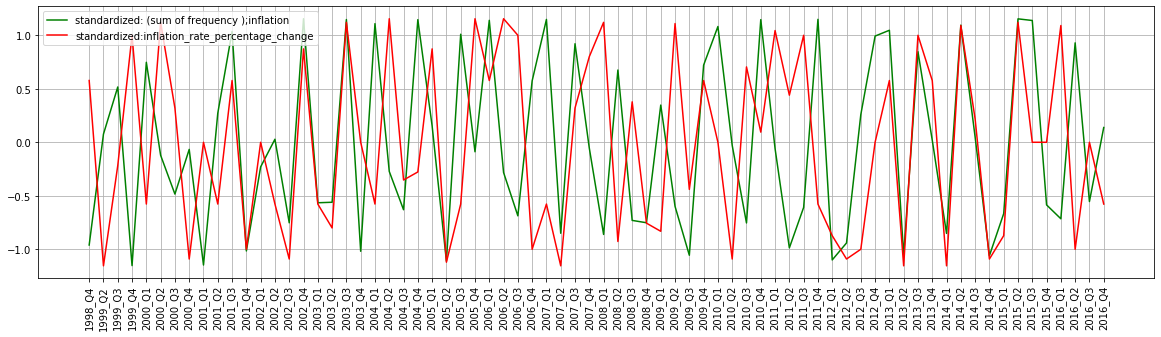

In [6]:
index_name = 'inflation_rate_percentage_change'
i = 'frequency'
x_ = proposed_data_x_dict[i][index_name]

x_ = list(map(lambda item: -item, x_))

y_ = fred_data_y_dict[index_name]
x_ticks_list = period_dict[index_name]
x_label = 'standardized: (sum of ' + i +' );'+target_keyword
y_label = 'standardized:' + index_name
show_plt_chart_rolling(x_, y_, x_ticks_list, rolling_window, x_label, y_label, max_lag=2)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.8487  , p=0.0960  , df_denom=68, df_num=1
ssr based chi2 test:   chi2=2.9743  , p=0.0846  , df=1
likelihood ratio test: chi2=2.9137  , p=0.0878  , df=1
parameter F test:         F=2.8487  , p=0.0960  , df_denom=68, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.3106  , p=0.2767  , df_denom=65, df_num=2
ssr based chi2 test:   chi2=2.8229  , p=0.2438  , df=2
likelihood ratio test: chi2=2.7675  , p=0.2506  , df=2
parameter F test:         F=1.3106  , p=0.2767  , df_denom=65, df_num=2


{1: ({'ssr_ftest': (2.848650395827382, 0.09603263400021882, 68.0, 1),
   'ssr_chi2test': (2.9743261485844728, 0.0845953491210866, 1),
   'lrtest': (2.9137130538342433, 0.08782945405435734, 1),
   'params_ftest': (2.8486503958273754, 0.09603263400021882, 68.0, 1.0)},
   array([[0., 1., 0.]])]),
 2: ({'ssr_ftest': (1.3106379024401542, 0.2766781613944845, 65.0, 2),
   'ssr_chi2test': (2.822912405255717, 0.2437880197934331, 2),
   'lrtest': (2.7674776134140586, 0.25063970565636967, 2),
   'params_ftest': (1.310637902440149, 0.2766781613944864, 65.0, 2.0)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])])}

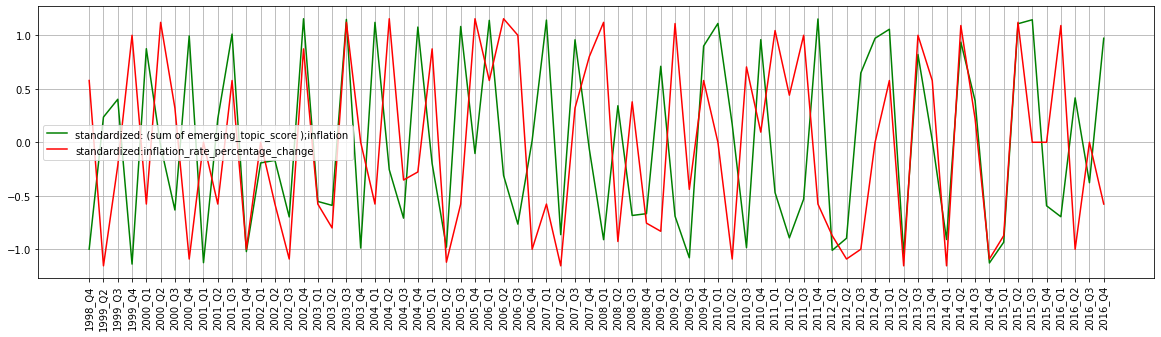

In [7]:
index_name = 'inflation_rate_percentage_change'
i = 'emerging_topic_score'
x_ = proposed_data_x_dict[i][index_name]

x_ = list(map(lambda item: -item, x_))

y_ = fred_data_y_dict[index_name]
x_ticks_list = period_dict[index_name]
x_label = 'standardized: (sum of ' + i +' );'+target_keyword
y_label = 'standardized:' + index_name
show_plt_chart_rolling(x_, y_, x_ticks_list, rolling_window, x_label, y_label, max_lag=2)

## not_aligned, Strength & Inflation Rate Percentage Change


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.5118  , p=0.0652  , df_denom=68, df_num=1
ssr based chi2 test:   chi2=3.6667  , p=0.0555  , df=1
likelihood ratio test: chi2=3.5752  , p=0.0586  , df=1
parameter F test:         F=3.5118  , p=0.0652  , df_denom=68, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.6547  , p=0.1991  , df_denom=65, df_num=2
ssr based chi2 test:   chi2=3.5640  , p=0.1683  , df=2
likelihood ratio test: chi2=3.4762  , p=0.1759  , df=2
parameter F test:         F=1.6547  , p=0.1991  , df_denom=65, df_num=2


{1: ({'ssr_ftest': (3.5117677054896603, 0.065231405324212, 68.0, 1),
   'ssr_chi2test': (3.6666986336730276, 0.055510033304471115, 1),
   'lrtest': (3.575156313530158, 0.05864992871405714, 1),
   'params_ftest': (3.511767705489652, 0.06523140532421232, 68.0, 1.0)},
   array([[0., 1., 0.]])]),
 2: ({'ssr_ftest': (1.6546969268589382, 0.1990994513183414, 65.0, 2),
   'ssr_chi2test': (3.5639626116961742, 0.16830435430337273, 2),
   'lrtest': (3.476201774177383, 0.17585405039502802, 2),
   'params_ftest': (1.6546969268589367, 0.1990994513183414, 65.0, 2.0)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])])}

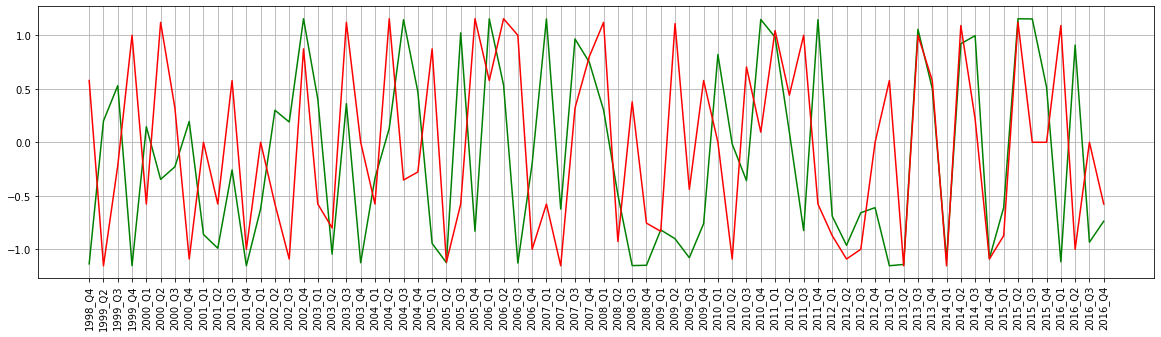

In [8]:
index_name = 'inflation_rate_percentage_change'
i = 'strength'
x_ = proposed_data_x_dict[i][index_name]

x_ = list(map(lambda item: -item, x_))

y_ = fred_data_y_dict[index_name]
x_ticks_list = period_dict[index_name]
x_label = 'standardized: (sum of ' + i +' );'+target_keyword
y_label = 'standardized:' + index_name
show_plt_chart_rolling(x_, y_, x_ticks_list, rolling_window, x_label, y_label, max_lag=2, with_legend=False)

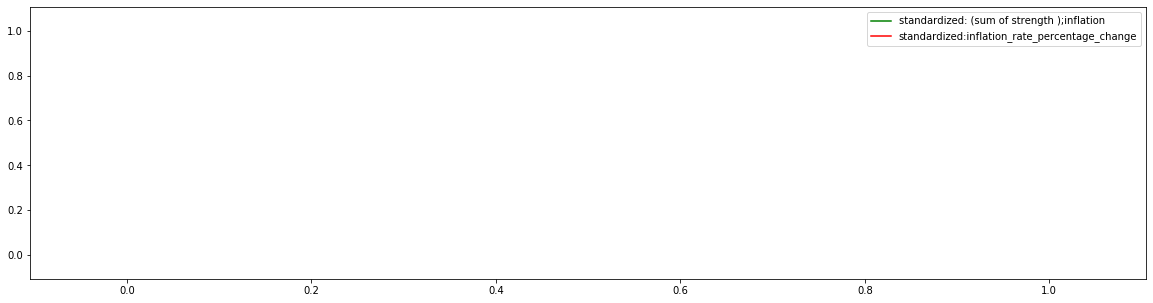

In [9]:
plt.plot([], 'g', label=x_label)
plt.plot([],'r', label=y_label)
plt.legend()

## Robustness check

In [10]:
# test
len(period_dict[index_name])

74

### Let's check!

#### Robust하지 못함

In [31]:
test_periods_dict = {1:(0,24),2:(24,48),3:(48,74)}
for s_, e_ in test_periods_dict.values():
    print(period_dict['inflation_rate_percentage_change'][s_:e_])

['1998_Q2', '1998_Q3', '1998_Q4', '1999_Q2', '1999_Q3', '1999_Q4', '2000_Q1', '2000_Q2', '2000_Q3', '2000_Q4', '2001_Q1', '2001_Q2', '2001_Q3', '2001_Q4', '2002_Q1', '2002_Q2', '2002_Q3', '2002_Q4', '2003_Q1', '2003_Q2', '2003_Q3', '2003_Q4', '2004_Q1', '2004_Q2']
['2004_Q3', '2004_Q4', '2005_Q1', '2005_Q2', '2005_Q3', '2005_Q4', '2006_Q1', '2006_Q2', '2006_Q3', '2006_Q4', '2007_Q1', '2007_Q2', '2007_Q3', '2007_Q4', '2008_Q1', '2008_Q2', '2008_Q3', '2008_Q4', '2009_Q1', '2009_Q2', '2009_Q3', '2009_Q4', '2010_Q1', '2010_Q2']
['2010_Q3', '2010_Q4', '2011_Q1', '2011_Q2', '2011_Q3', '2011_Q4', '2012_Q1', '2012_Q2', '2012_Q3', '2012_Q4', '2013_Q1', '2013_Q2', '2013_Q3', '2013_Q4', '2014_Q1', '2014_Q2', '2014_Q3', '2014_Q4', '2015_Q1', '2015_Q2', '2015_Q3', '2015_Q4', '2016_Q1', '2016_Q2', '2016_Q3', '2016_Q4']


In [33]:
max_lag = 2

to_check_list = list()

indices = ['inflation_rate_percentage_change']
for index_name in indices:
    for i in ['frequency', 'strength', 'emerging_topic_score']:
        for test_key, (s_, e_) in test_periods_dict.items():
            x_ = proposed_data_x_dict[i][index_name][s_:e_]
            y_ = fred_data_y_dict[index_name][s_:e_]
            x_ticks_list = period_dict[index_name][s_:e_]
            x_label = 'standardized: (sum of ' + i +' );'+target_keyword
            y_label = 'standardized:' + index_name
            df = show_plt_chart_rolling(x_, y_, x_ticks_list, rolling_window, x_label, y_label, max_lag=max_lag, with_legend=False, show=False)

            print('\n\n','='*10)
            title = index_name + ',   ' + str(i) + ',   test_period=' + str(test_key)
            print(title)
            print('='*10)
            print('n_lag \t p-value')
            for n_lag in range(1, max_lag+1):
                p_value_str = '%.4f' % df[n_lag][0]['params_ftest'][1]
                if float(p_value_str) < 0.1:
                    p_value_str += '★'
                    to_check_list.append(title)
                elif float(p_value_str) < 0.05:
                    p_value_str += '★★'
                    to_check_list.append(title)
                print('%d \t %s'% (n_lag, p_value_str))


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.0809  , p=0.0962  , df_denom=18, df_num=1
ssr based chi2 test:   chi2=3.5944  , p=0.0580  , df=1
likelihood ratio test: chi2=3.3179  , p=0.0685  , df=1
parameter F test:         F=3.0809  , p=0.0962  , df_denom=18, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.7719  , p=0.4796  , df_denom=15, df_num=2
ssr based chi2 test:   chi2=2.0584  , p=0.3573  , df=2
likelihood ratio test: chi2=1.9592  , p=0.3755  , df=2
parameter F test:         F=0.7719  , p=0.4796  , df_denom=15, df_num=2


inflation_rate_percentage_change,   frequency,   test_period=1
n_lag 	 p-value
1 	 0.0962★
2 	 0.4796

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.9407  , p=0.3449  , df_denom=18, df_num=1
ssr based chi2 test:   chi2=1.0975  , p=0.2948  , df=1
likelihood ratio test: chi2=1.0698  , p=0.3010  , df=1
parameter F test:         F=0.9407  , p=0.3449  , df_denom=18, df_nu